# ДЗ №1 - обучение модели линейной регресии методом градиентного спуска

Реализовать обучение модели линейной регрессии методом градиентного спуска.<br />

В качестве подводящего упражнения в этом задании предлагается реализовать функции потерь и саму модель линейной регрессии в манере, схожей с построением модулей фреймворка pytorch (см. пояснения в шаблонах кода)

В решении ожидается наличие следующих ключевых составляющих:<br />

#### Текстовое описание в решении:
- формулировка задачи, формулировка признакового описания объектов, формулировка функции ошибки, формулировка меры качества модели;
- исследование исходных данных на предмет скоррелированности признаков; фильтрация признаков; порождение признаков (при необходимости);
- оценка параметров модели линейной регрессии (обучение модели) методом градиентного спуска;
- оценка качества модели на валидационной выборке.

#### Код решения:
(используйте предлагаемые шаблоны)
- формулировка модели линейной регрессии;
- формулировка функции ошибки;
- формулировка метрики (метрик);
- формулировка цикла оптимизации параметров.


#### Визуализация в решении:
- распределение признаков;
- распределение целевой переменной;
- эволюция функции ошибки и выбранных метрик качества по ходу обучения.

#### Выводы (в форме текста!)
- вывод о том, насколько модель подходит для описания данных
- вывод о достаточности или избыточности данных для оценки параметров модели
- вывод о соотношении выразительности модели и ее обобщающей способности (наблюдаются ли явления переобучения или недообучения).

Примечания:<br />
Допустимо порождение признаков (полиномиальных, экспоненциальных, логарифмических, etc.)<br />
Реализация линейной регрессии может быть написана только с использованием библиотеки Numpy. Решения с использованием библиотек автоматического вычисления градиентов не засчитываются.<br />
Из готовых реализаций (напр., из пакета scikit-learn) в этом задании допускается использовать только порождение полиномиальных признаков `PolynomialFeatures`.

Данные находятся в следующих файлах:

Признаковое описание объектов обучающей выборки - в файле X_train.npy

Значения целевой переменной на обучающей выборке - в файле y_train.npy

Способ чтения данных из файлов *.npy :

```
import numpy as np
data = np.load('/path/to/filename.npy')
```

### Примечание на предмет реализации градиента функции потерь

Нелишним будет вспомнить способ вычисления градиента сложной функции. Здесь функция ошибки (обозначено как $\mathscr{L}$) представлена как сложная функция $\mathscr{L}\left( G\left( \theta \right) \right)$. Для простоты приведена сразу матричная запись.

$$
\nabla_{\theta}{\mathscr{L}} = \nabla_{\theta}{G}\cdot\left(\nabla_{G}{\mathscr{L}}\right)
$$

В качестве шпаргалки можно подсмотреть правила матричного дифференцирования <a href="https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf">здесь</a>

Например, в случае функции потерь MSE это может выглядеть следующим образом:

$$
\nabla_{\theta}{\mathscr{L}} = X^T\cdot2\left(X\theta - Y\right)
$$


При этом логически имеет смысл реализовать компоненту градиента, относящуюся собственно к функции потерь $\nabla_{G}{\mathscr{L}}$ - в коде класса функции потерь, а компоненту, относящуюся к модели $\nabla_{\theta}{G}$ - в коде модели.

Именно поэтому классы `loss` и `linear_regression` в предложенном шаблоне реализованы наследующими `Differentiable` - для общности восприятия этих модулей как дифференцируемых по своим аргументам.

In [1]:
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

In [4]:
Xtr = np.load('./X_train.npy')
ytr = np.load('./y_train.npy')

В чем стоит наша задача? Нам необходимо обучить модель линейной регресии методом градиентного спуска. Применяя градиентный спуск, мы модифицируем веса нашей модели и в конце концов получаем вектор весов, который максимально близко прогнозирует целевую переменную при перемножении с исходным датасетом.

Мы загрузили наши данные, теперь нам необходимо разбить их на train и test части. Обучать модель мы будем на train сете, а тестировать соответственно на test. Для разбиения я решил воспользоваться фукнцией train_test_split из библиотеки sklearn. Разбивать будем в отношении 80/20.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xtr, ytr, test_size=0.2, random_state=42)

После того, как мы разбили данные, хочется узнать о том, что у нас вообще лежит в наших датасетах, каких размеров и т.д.

In [6]:
print("Shape of train =", X_train.shape)
print("Shape of target =", y_train.shape)

Shape of train = (8000, 4)
Shape of target = (8000, 1)


Итак, у нас 4 признака и 8000 объектов. Будем исследовать их зависимости.

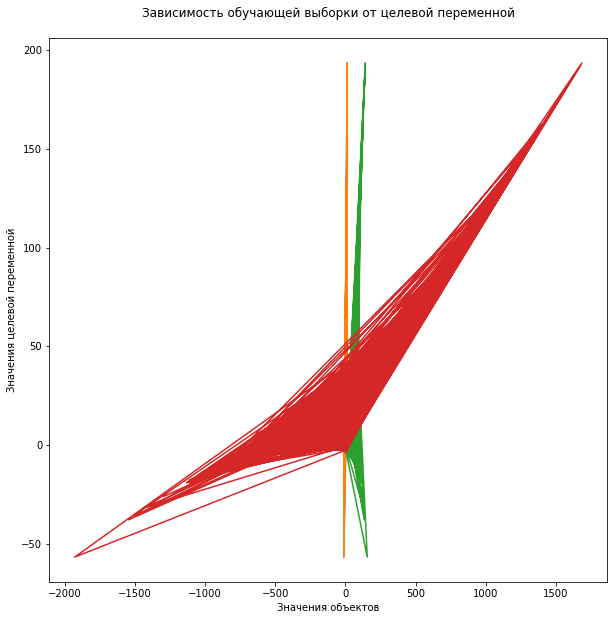

In [7]:
plt.figure(figsize=(10,10))
plt.plot(X_train, y_train)
plt.title('Зависимость обучающей выборки от целевой переменной\n')
plt.xlabel('Значения объектов')
plt.ylabel('Значения целевой переменной')
plt.show()

Не сказать, что этот график говорит нам о чем-то стоящем...
Поэтому имеет смысл рассмотреть зависимость каждого из признаков от целевой переменной в отдельности.

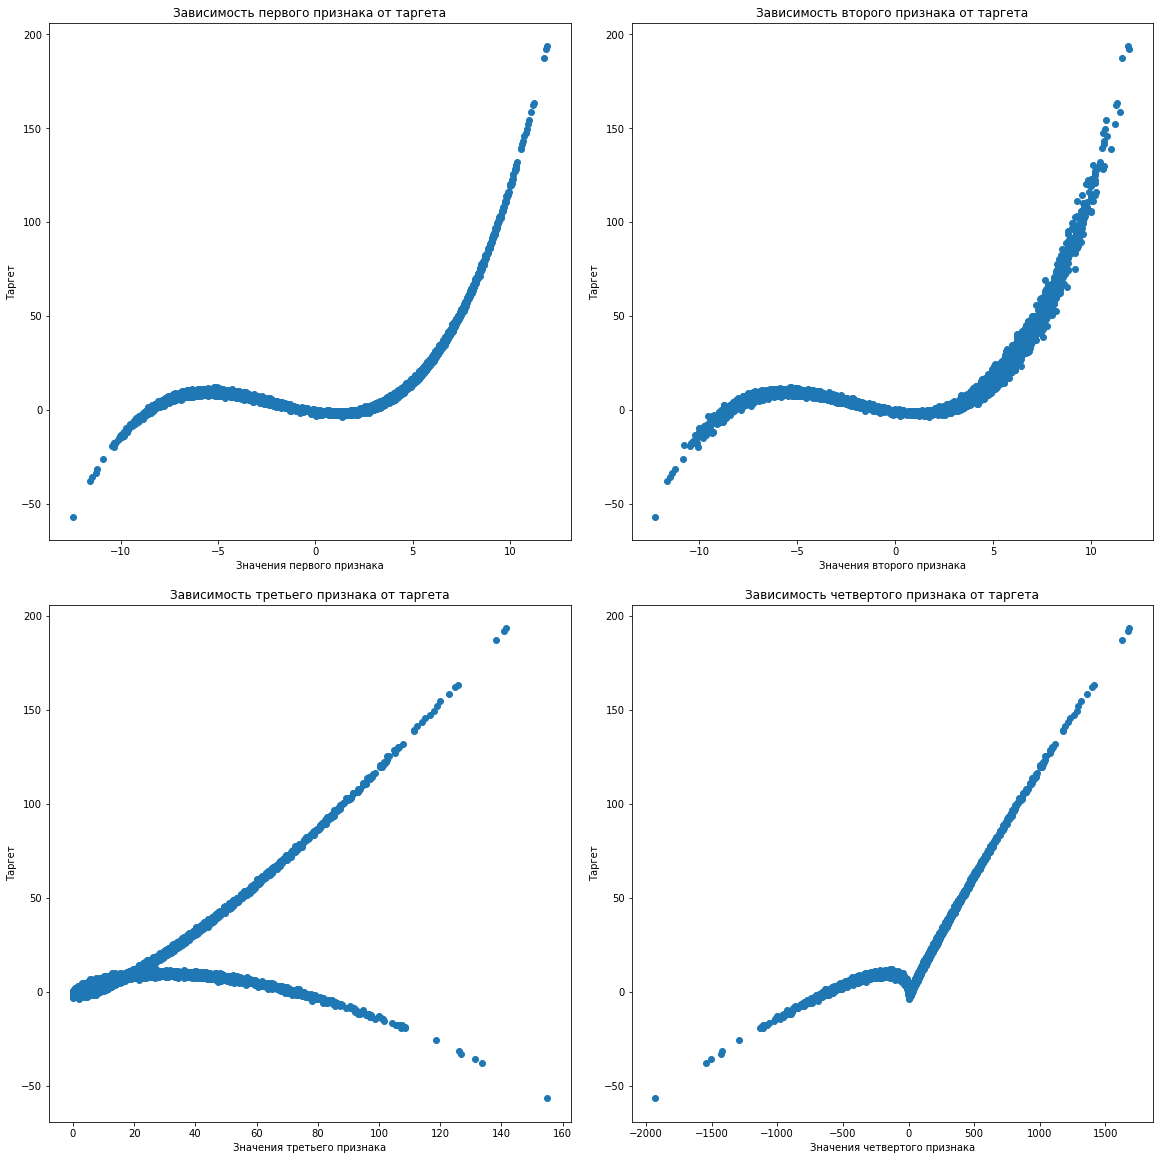

In [8]:
fig, axs = plt.subplots(figsize=(16, 16), ncols = 2, nrows = 2, constrained_layout=True)

axs[0][0].scatter(X_train[:, 0], y_train, label="Data")
axs[0][0].set_title("Зависимость первого признака от таргета")
axs[0][0].set_xlabel("Значения первого признака")
axs[0][0].set_ylabel("Таргет")

axs[0][1].scatter(X_train[:, 1], y_train, label="Data")
axs[0][1].set_title("Зависимость второго признака от таргета")
axs[0][1].set_xlabel("Значения второго признака")
axs[0][1].set_ylabel("Таргет")

axs[1][0].scatter(X_train[:, 2], y_train, label="Data")
axs[1][0].set_title("Зависимость третьего признака от таргета")
axs[1][0].set_xlabel("Значения третьего признака")
axs[1][0].set_ylabel("Таргет")

axs[1][1].scatter(X_train[:, 3], y_train, label="Data")
axs[1][1].set_title("Зависимость четвертого признака от таргета")
axs[1][1].set_xlabel("Значения четвертого признака")
axs[1][1].set_ylabel("Таргет")

plt.show()

На этих четырех графиках можно заметить схожесть 1-ого и 2-ого признаков. Попробуем проверить их зависимость друг от друга, посмотрев на матрицу корреляций нашего датасета. Также у признаков прослеживается линейная часть, что говорит о том, что можно применять линейную регрессию для обучения.

In [9]:
np.corrcoef([X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3], y_train[:, 0]])

array([[1.        , 0.99931918, 0.00830183, 0.88017496, 0.59613312],
       [0.99931918, 1.        , 0.00895338, 0.87959698, 0.59584718],
       [0.00830183, 0.00895338, 1.        , 0.02233342, 0.60108128],
       [0.88017496, 0.87959698, 0.02233342, 1.        , 0.78816548],
       [0.59613312, 0.59584718, 0.60108128, 0.78816548, 1.        ]])

Как мы предположили ранее, 1-ый и 2-ый признаки линейно зависимы (коэффициент корреляции почти 1), имеет смысл избавиться от одного их них перед обучением. В последней строке матрицы можем увидеть будущее влияние каждого признака на обучение, наибольший вклад будет давать 4-ый признак. 

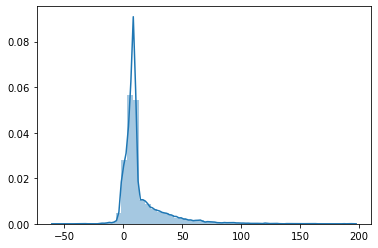

In [10]:
sns.distplot(y_train)

Если посмотрим на распредление целевой переменной, то можно заметить, что выбросов, которые могли бы навредить обучению модели, нет, поэтому все ок.

Перед началом обучения модели имеет смысл стандартизировать наши данные. Используем для этого Standart Scaler из библиотеки sklearn. Применяя Standard Scaler к выборке мы вычитаем из каждого признака среднее и делим на стандартное отклонение.

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
class Differentiable:
    def __init__(self):
        pass
    
    def forward(self, **kwargs):
        raise NotImplementedError()
    
    def backward(self, **kwargs):
        raise NotImplementedError()

Перед тем, как перейти к организации градиентного спуска, стоит сказать, что я решил выбрать функцию ошибки MSE.

In [13]:
class loss(Differentiable):
    def __init__(self):
        super(loss, self).__init__()
    
    def forward(self, y_pred, y_true):
        # Метод реализует вычисление значения функции потерь
        loss_value = 0.0     
        loss_value = np.sum((y_pred - y_true) ** 2) / len(y_true) #MSE
                
        return loss_value
    
    
    def backward(self, y_pred, y_true):
        # Метод реализует вычисление градиента функции потерь по аргументу y_pred
        
        partial_grad = np.zeros_like(y_pred-y_true)
        partial_grad = 2 * (y_pred - y_true) / len(y_true) 
        
        return partial_grad

In [14]:
class linear_regression(Differentiable):
    def __init__(self):
        super(linear_regression, self).__init__()
        self.theta = None
    
    def __call__(self, X):
        # Метод предназначен для вычисления значения целевой переменной
        return self.forward(X)
    
    def backward(self, X):
        # Метод реализует вычисление компоненты градиента функции потерь       
        partial_grad = 0.0
        
        partial_grad = np.transpose(X)
        
        return partial_grad
    
    def forward(self, X):
        # Метод предназначен для применения модели к данным
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        
        n, k = X.shape
        
        if (self.theta is None):
            self.theta = np.random.rand(k, 1)
               
        y_pred = np.dot(X, self.theta)
        
        return y_pred

В методе forward предлагают расширить матрицу X дополнительным признаком, я реализую это ниже и соотвественно в forward буду подавать уже расширенную матрицу, а следовательно self.theta будет генерировать вектор вместе с bias.

In [15]:
def train_loop(X, y, model, loss_fn, epochs=100):
    loss_history = []
    pbar = tqdm(total=epochs)
    
    lr = 0.1 #learning rate
    
    for epoch in range(epochs):
        # В этом цикле следует реализовать итеративную процедуру оптимизации параметров модели model,
        #        руководствуясь функцией потерь loss_fn
        y_pred = model.__call__(X)
        loss_value = loss_fn.forward(y_pred, y)
        X_T = model.backward(X)
        grad = np.dot(X_T, loss_fn.backward(y_pred, y))
        model.theta -= lr * grad
        
        loss_history.append(loss_value)
        pbar.update(1)
        pbar.set_postfix({'loss': loss_value})
    pbar.close()
    return loss_history

Мы готовы обучать нашу модель, но перед этим расширим матрицу допольнительным признаком и удалим линейно зависимый 2-ой признак.

In [16]:
n, k = X_train_scaled.shape
b = np.ones(n)
X_train_scaled_new = np.column_stack((X_train_scaled, b))
X_train_scaled_new = np.delete(X_train_scaled_new, 1, 1)

u, v = X_test_scaled.shape
b = np.ones(u)
X_test_scaled_new = np.column_stack((X_test_scaled, b))
X_test_scaled_new = np.delete(X_test_scaled_new, 1, 1)

In [17]:
obj_fn = loss()
lr_model = linear_regression()
loss_history = train_loop(X_train_scaled_new, y_train, lr_model, obj_fn, epochs=1000)

100%|█████████████████████████████████████████████| 1000/1000 [00:01<00:00, 811.86it/s, loss=0.525]


Посмотрим на эволюцию лосса во время обучения. Можем заметить, после опредленного момент loss value перестал меняться и остался равным ~0.525. Кажется, что мы пришли в минимум и полностью обучились.

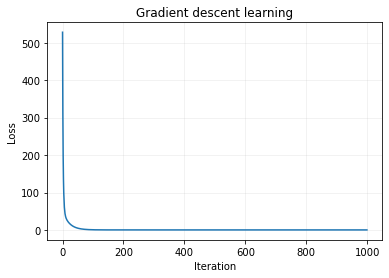

In [18]:
plt.plot(loss_history)
plt.title('Gradient descent learning')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(alpha=0.2)
plt.show()

Теперь нам хотелось бы оценить нашу модель. В качестве метрики возьмем всё тот же MSE. Прежде чем увидеть наше значение MSE на train и test выборках, стоит понять от какого значение стоит отталкиваться, чтобы понять хорошо или плохо обучилась наша модель. Для этого посчитаем MSE для среднего значения нашей train выборки.

In [19]:
from sklearn.metrics import mean_squared_error

best_constant = y_train.mean()
print("Train MSE with best constant = %.4f" % obj_fn.forward(best_constant * np.ones(y_train.shape), y_train))
print("Test MSE with best constant = %.4f" % obj_fn.forward(best_constant * np.ones(y_test.shape), y_test))

Train MSE with best constant = 366.9335
Test MSE with best constant = 333.4658


Имея "точку отсчета" можем посмотреть насколько хорошо или плохо обучилась наша модель

In [20]:
print("Train MSE = %.4f" % obj_fn.forward(X_train_scaled_new @ lr_model.theta, y_train))
print("Test MSE = %.4f" % obj_fn.forward(X_test_scaled_new @ lr_model.theta, y_test))

Train MSE = 0.5251
Test MSE = 0.5406


Видим, что наша модель обучилась довольно хорошо. Значения гораздо лучше, чем на среднем значении. Переобучения не произошло, результат на тестовой выборке не существенно отличается от результата на обучающей.

Еще один вариант оценить нашу модель, использовать коэффициент детерминации. Грубо говоря, данная мера качества — это нормированная среднеквадратичная ошибка. Если она близка к единице, то модель хорошо объясняет данные, если же она близка к нулю, то прогнозы сопоставимы по качеству с константным предсказанием.

In [21]:
from sklearn.metrics import r2_score

print("Train R2 score = %.6f" % r2_score(y_train, X_train_scaled_new @ lr_model.theta))
print("Test R2 score = %.6f" % r2_score(y_test, X_test_scaled_new @ lr_model.theta))

Train R2 score = 0.998569
Test R2 score = 0.998379


Видим, что значение почти равно единице, а значит нам отлично подошла линейная регрессия с градиентным спуском для обучения модели.

Посмотрим на то какие прямые мы можем построить с весами нашей модели. 

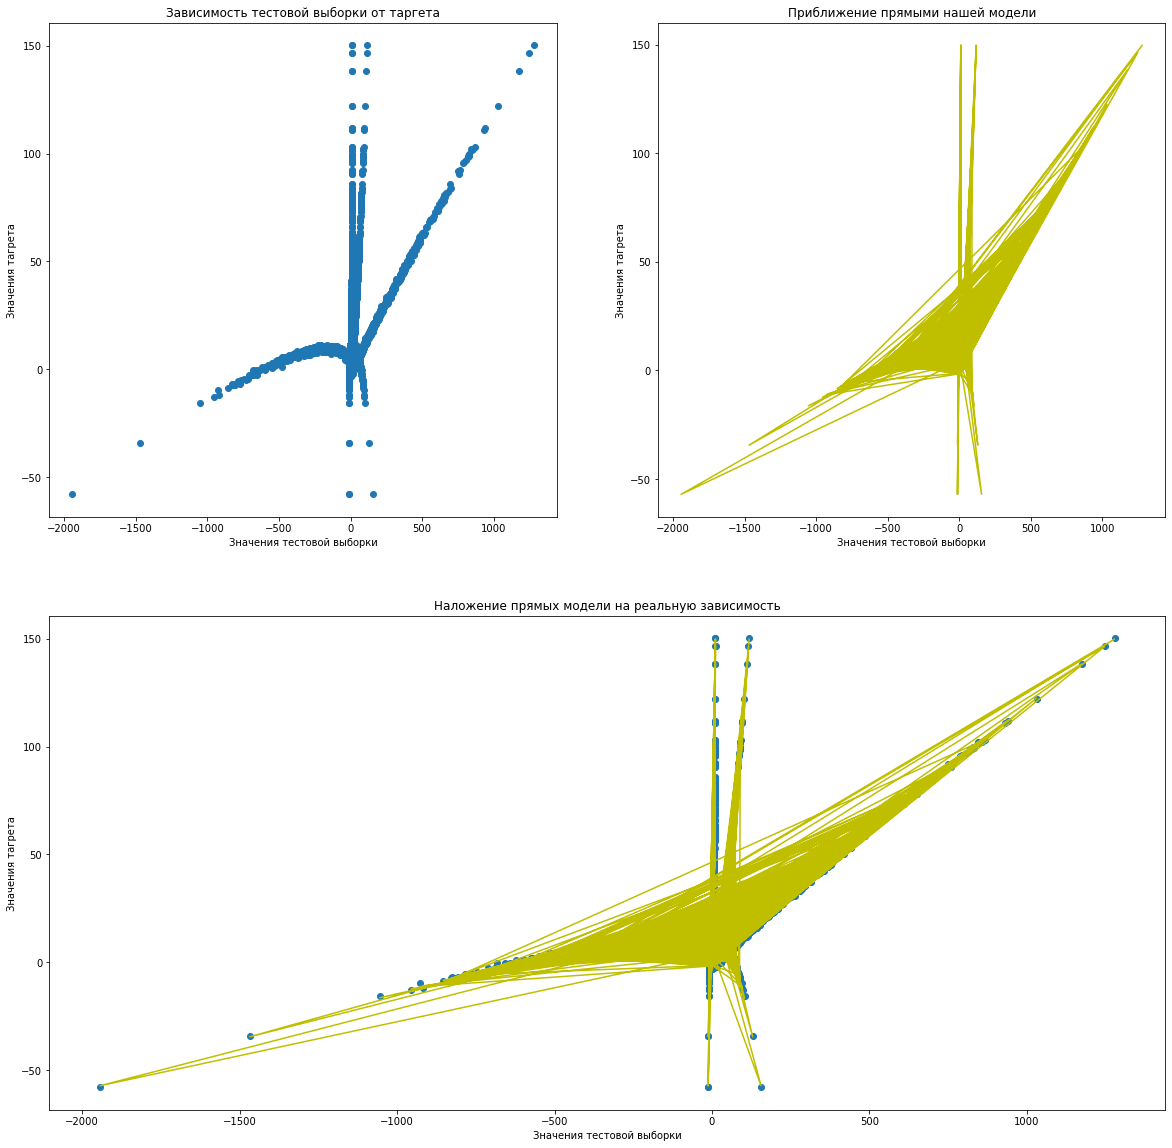

In [22]:
fig = plt.figure(figsize = (20, 20))
ax1 = plt.subplot(221)
ax1.scatter(X_test, y_test * np.ones(4))
ax1.set_title('Зависимость тестовой выборки от таргета')
ax1.set_xlabel('Значения тестовой выборки')
ax1.set_ylabel('Значения тагрета')

ax2 = plt.subplot(222)
ax2.plot(X_test, X_test_scaled_new @ lr_model.theta, c='y')
ax2.set_title('Приближение прямыми нашей модели')
ax2.set_xlabel('Значения тестовой выборки')
ax2.set_ylabel('Значения тагрета')

ax3 = plt.subplot(212)
ax3.scatter(X_test, y_test * np.ones(4))
ax3.plot(X_test, X_test_scaled_new @ lr_model.theta, c='y')
ax3.set_title('Наложение прямых модели на реальную зависимость')
ax3.set_xlabel('Значения тестовой выборки')
ax3.set_ylabel('Значения тагрета')

plt.show()